# SysArmy - Análisis de encuesta 2020.02

## 1. Carga y sanitización de datos

###  1.1. Definimos los metadatos asociados al dataset que vamos a analizar

In [1]:
%load_ext nb_black

csv_url = "https://raw.githubusercontent.com/openqube/openqube-sueldos/release/2020.02/data/csv/argentina/2020.02.csv"

dataset_metadata = {
    "year": 2020,
    "part": 2,
    "skiprows": 0,
    "publish_date": "2020-08-15",
    "minimum_salary": 16875,  # https://es.wikipedia.org/wiki/Anexo:Salario_m%C3%ADnimo_en_Argentina
}

<IPython.core.display.Javascript object>

### 1.2. En base a los metadatos, cargamos el CSV, limpiamos columnas y las transformamos

In [2]:
import pandas as pd
import io
import requests
from time import sleep
import matplotlib.pyplot as plt

raw_dataframe = None
source = requests.get(
    csv_url.format(dataset_metadata["year"], dataset_metadata["part"])
).content
raw_dataframe = pd.read_csv(
    io.StringIO(source.decode("utf-8")),
    skiprows=dataset_metadata["skiprows"],
    thousands=".",
    decimal=",",
)

# resultados que no pertenezcan a Argentina quedan fuera de este análisis
columns_to_remove = [
    "Bolivia",
    "Chile",
    "Colombia",
    "Cuba",
    "Costa Rica",
    "Ecuador",
    "El Salvador",
    "Guatemala",
    "Honduras",
    "México",
    "Nicaragua",
    "Panamá",
    "Paraguay",
    "Perú",
    "Puerto Rico",
    "República Dominicana",
    "Uruguay",
    "Venezuela",
]

raw_dataframe.drop(columns_to_remove, axis=1, inplace=True)

import re

regex_white_chars = re.compile(r"\s+")
regex_non_alphanum = re.compile(r"\W+_?", re.I)

raw_dataframe.columns = (
    raw_dataframe.columns.str.strip()
    .str.lower()
    .str.replace(regex_white_chars, "_")
    .str.replace(regex_non_alphanum, "")
    .str.translate(
        "ñáéíóú".maketrans({"ñ": "n", "á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u"})
    )
)

# Eliminamos los datos que no pertenezcan a Argentina
raw_dataframe = raw_dataframe[raw_dataframe["estoy_trabajando_en"] == "Argentina"]

dataframe = raw_dataframe.copy()

display([column for column in dataframe.columns])

['timestamp',
 'me_identifico',
 'tengo',
 'estoy_trabajando_en',
 'donde_estas_trabajando',
 'anos_de_experiencia',
 'anos_en_la_empresa_actual',
 'anos_en_el_puesto_actual',
 'gente_a_cargo',
 'nivel_de_estudios_alcanzado',
 'estado',
 'carrera',
 'universidad',
 'realizaste_cursos_de_especializacion',
 'contribuis_a_proyectos_open_source',
 'programas_como_hobbie',
 'trabajo_de',
 'plataformas',
 'lenguajes_de_programacion',
 'frameworksherramientas_y_librerias',
 'bases_de_datos',
 'qa_testing',
 'ides',
 'que_so_usas_en_tu_laptoppc_para_trabajar',
 'y_en_tu_celular',
 'tenes_guardias',
 'cuanto_cobras_por_guardia',
 'porcentajebruto_o_neto',
 'tipo_de_contrato',
 'salario_mensual_bruto_en_tu_moneda_local',
 'salario_mensual_neto_en_tu_moneda_local',
 'unnamed49',
 'que_tan_conforme_estas_con_tu_sueldo',
 'como_crees_que_esta_tu_sueldo_con_respecto_al_ultimo_semestre',
 'recibis_algun_tipo_de_bono',
 'a_que_esta_atado_el_bono',
 'tuviste_ajustes_por_inflacion_en_lo_que_va_de_2020',

<IPython.core.display.Javascript object>

### 1.3. Echamos un vistazo al dataframe previo a sanitizarlo

In [3]:
raw_dataframe.T.head()

,0,1,2,3,4,5,6,7,8,9,...,6405,6406,6407,6408,6409,6410,6411,6412,6413,6414
timestamp,7/6/2020 9:56:02,7/6/2020 9:57:09,7/6/2020 9:58:09,7/6/2020 9:59:52,7/6/2020 10:01:27,7/6/2020 10:03:13,7/6/2020 10:04:00,7/6/2020 10:04:01,7/6/2020 10:05:13,7/6/2020 10:07:13,...,8/15/2020 17:12:47,8/15/2020 17:13:01,8/15/2020 17:18:17,8/15/2020 17:21:22,8/15/2020 17:32:12,8/15/2020 22:04:58,8/15/2020 22:48:40,8/15/2020 23:54:10,8/16/2020 0:45:57,8/16/2020 1:03:20
me_identifico,Mujer,Hombre,Mujer,Hombre,Hombre,Hombre,Hombre,Hombre,Hombre,Otros,...,Hombre,Hombre,Hombre,Hombre,Hombre,Hombre,Hombre,Hombre,Hombre,Hombre
tengo,26,29,22,39,32,25,33,23,40,35,...,34,52,43,32,32,37,38,24,28,33
estoy_trabajando_en,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,...,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina
donde_estas_trabajando,Ciudad Autónoma de Buenos Aires,Corrientes,Ciudad Autónoma de Buenos Aires,Corrientes,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Provincia de Buenos Aires,Entre Ríos,Ciudad Autónoma de Buenos Aires,...,Ciudad Autónoma de Buenos Aires,Santa Fe,Ciudad Autónoma de Buenos Aires,Provincia de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,La Pampa,GBA


<IPython.core.display.Javascript object>

### 1.4. Sanitizamos/normalizamos datos que encontramos mal formados o repetidos

In [4]:
import re


def normalize_dataframe_column(df_in, column_name, regex_assign_map):
    """
  Given a Dataframe (df), a column name that identifies the column to sanitize,
  applies an in-place replacement for each pair regex-value in the map
  """
    df_out = df_in.copy()
    for regex, value in regex_assign_map.items():
        compiled_regex = re.compile(regex, re.I)
        mask = df_in[column_name].str.strip().str.match(compiled_regex, na=False)
        df_out.loc[mask, column_name] = value

    # debug
    total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
    display("reduced in {:02f}".format((total - final) / total))
    return df_out


def normalize_dataframe_column_replace(df_in, column_name, regex_replace_map):
    """
  Given a Dataframe (df), a column name that identifies the column to sanitize,
  applies an in-place replacement for each pair regex-value in the map
  """
    df_out = df_in.copy()
    for regex, pattern in regex_replace_map.items():
        compiled_regex = re.compile(regex, re.I)
        df_out[column_name] = (
            df_out[column_name].str.strip().str.replace(compiled_regex, pattern)
        )

    # debug
    total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
    display("reduced in {:02f}".format((total - final) / total))
    return df_out

<IPython.core.display.Javascript object>

#### 1.4.1. Carreras

In [5]:
dataframe = normalize_dataframe_column_replace(
    dataframe,
    "carrera",
    {
        "(Derecho|Abogac[íi]a|abogad.)": "Derecho",
        "(Contador.*)": "Contador Público",
        "(Arquitect(o|a|ura))": "Arquitectura",
        "(Lic.*)?Psicolog[íi]a": "Licenciatura en Psicología",
        "(Lic.*)?Marketing": "Licenciatura en Marketing",
        ".*Comunicación": "Licenciatura en Comunicación",
        "Letras": "Licenciatura en Letras",
        "Tec.*Infraestructuras{0,2}": "Tecnicatura Superior en Soporte de Infraestructuras",
        "(lic.*qu[ií]mica)": "Licenciatura en Química",
        "^(RRHH|Trabajo)": "Licenciatura en Relaciones del Trabajo",
        "(Lic.*)?Administraci[oó]n( de empresas)?": "Licenciatura en Administración de Empresas",
        "Ed.*f[ií]sica": "Educación Física",
        "Licenciatura en Cienciasdela Computación": "Licenciatura en Ciencias de la Computación",
        "Licenciatura en Ciencias dela Computación": "Licenciatura en Ciencias de la Computación",
        "(ningun(a|o)|-)": "DELETEME",
        "Lic.* Matemáticas?": "Licenciatura en Matemática",
        "(lic.*)econom[íi]a": "Licenciatura en Economía",
        "ingenier[íi]a de sistemas": "Ingeniería en Sistemas",
        "^(.*)\.$": "\\1",
    },
)

df = dataframe["carrera"].value_counts(sort=True)
display(df[:55])

'reduced in 0.122984'

Ingeniería en Sistemas de Información                  1194
Ingeniería en Informática                               784
Analista de Sistemas                                    596
Licenciatura en Ciencias de la Computación              300
Licenciatura en Sistemas de Información                 298
Licenciatura en Informática                             256
Tecnicatura en Programación                             190
Ingeniería Electrónica                                  155
Diseño Gráfico                                          139
Tecnicatura Superior en Programación                    134
Ingeniería en Computación                               118
Licenciatura en Análisis de Sistemas                    102
Tecnicatura en Informática                               90
Licenciatura en Administración de Empresas               85
Analista Programador                                     75
Tecnicatura Superior en Sistemas Informáticos            72
Analista Programador Universitario      

<IPython.core.display.Javascript object>

#### 1.4.2. Universidades

In [6]:
# En Mendoza se asocia UM a la Universidad de Mendoza, y en Buenos Aires, a la Universidad de Morón
mask = dataframe.eval(
    'universidad in ["UM", "Um"] and donde_estas_trabajando == "Mendoza"'
)
dataframe.universidad.loc[mask] = "Universidad Nacional de Mendoza"
display(dataframe[mask].universidad)

/home/nad/.pyenv/versions/system-3.8.5/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


4066    Universidad Nacional de Mendoza
Name: universidad, dtype: object

<IPython.core.display.Javascript object>

In [7]:
dataframe = normalize_dataframe_column(
    dataframe,
    "universidad",
    {
        "(UNSJ|.*Nacional de San Juan)": "UNSJ - Universidad Nacional de San Juan",
        "IRSO": "IRSO - Instituto Raúl Scalabrini Ortíz",
        "(UNPSJB|.*Patagonia San Juan Bosco.*)": "UNPSJB - Universidad Nacional de la Patagonia San Juan Bosco",
        "(UNSL|Universidad Nacional de San Luis)": "UNSL - Universidad Nacional de San Luis",
        "IFTS18": "IFTS18 - Instituto de Formación Técnica Superior N°18",
        "UCASAL": "UCASAL - Universidad Católica de Salta",
        "Universidad de Mendoza": "UM - Universidad de Mendoza",
        "UNTREF": "UNTREF - Universidad Nacional de Tres de Febrero",
        "(UNL[uU]|Universidad Nacional de Luj[aá]n)": "UNLu - Universidad Nacional de Luján",
        "(UAA|.*Atl[aá]ntida.*)": "UAA - Universidad Atlántida Argentina",
        "([fF]?IUPFA)": "IUPFA - Instituto Universitario de la Policía Federal Argentina",
        "([uU]?FASTA)": "FASTA - Fraternidad de Agrupaciones Santo Tomás de Aquino",
        "(UCSE)": "UCSE - Universidad Católica de Santiago del Estero",
        "(ISIV|.*Virasoro.*)": "ISIV - Instituto Superior de Informática Virasoro",
        "(UN[Aa]M)": "UNaM - Universidad Nacional de Misiones",
        "(-|ninguna)$": "DELETEME",
    },
)

df = dataframe["universidad"].value_counts(sort=True)
display(df[:60])

'reduced in 0.080000'

UTN - Universidad Tecnológica Nacional                                        1378
UBA - Universidad de Buenos Aires                                              785
UNLaM - Universidad Nacional de La Matanza                                     236
UADE - Universidad Argentina De la Empresa                                     204
UAI - Universidad Abierta Interamericana                                       193
UNLP - Universidad Nacional de La Plata                                        184
ORT                                                                            113
UP - Universidad de Palermo                                                    110
Universidad Siglo 21                                                           103
UNC - Universidad Nacional de Córdoba                                           94
UCAECE - Centro de Altos Estudios en Ciencias Exactas                           70
UNICEN - Universidad Nacional del Centro de la Provincia de Buenos Aires        68
Escu

<IPython.core.display.Javascript object>

#### 1.4.3. Experiencia

In [8]:
dataframe["anos_de_experiencia"] = dataframe["anos_de_experiencia"].astype(int)
dataframe["anos_en_la_empresa_actual"] = dataframe["anos_en_la_empresa_actual"].astype(
    int
)
dataframe["anos_en_el_puesto_actual"] = dataframe["anos_en_el_puesto_actual"].astype(
    int
)

<IPython.core.display.Javascript object>

#### 1.4.4. Regiones

In [9]:
dataframe = normalize_dataframe_column(
    dataframe,
    "donde_estas_trabajando",
    {"(GBA|Provincia de Buenos Aires)": "Buenos Aires",},
)

display(dataframe["donde_estas_trabajando"].unique())

'reduced in 0.040000'

array(['Ciudad Autónoma de Buenos Aires', 'Corrientes', 'Buenos Aires',
       'Entre Ríos', 'Córdoba', 'Tucumán', 'Santa Fe', 'Neuquén',
       'Mendoza', 'Misiones', 'Chaco', 'Chubut', 'Jujuy', 'La Rioja',
       'Río Negro', 'Salta', 'Tierra del Fuego', 'San Luis', 'Catamarca',
       'San Juan', 'Santiago del Estero', 'La Pampa', 'Formosa',
       'Santa Cruz'], dtype=object)

<IPython.core.display.Javascript object>

#### 1.4.5. Discapacidad

In [10]:
dataframe = normalize_dataframe_column(
    dataframe,
    "tenes_algun_tipo_de_discapacidad",
    {
        "^(_|-|no( tengo)?|ningun[oa]|nada|0|ni)$": None,
        ".*auditiv[oa].*": "Auditiva",
        ".*visual.*": "Visual",
        "mental": "Mental",
        "motriz": "Motriz",
        "vis?ceral": "Visceral",
        "^(sobrepeso|obesidad)": "Obesidad",
    },
)

df = dataframe["tenes_algun_tipo_de_discapacidad"].value_counts(sort=True)
display(df[:6])

'reduced in 0.333333'

Visual      337
Auditiva     39
Motriz       16
Mental       13
Visceral      5
Obesidad      4
Name: tenes_algun_tipo_de_discapacidad, dtype: int64

<IPython.core.display.Javascript object>

#### 1.4.5. Roles

In [11]:
dataframe = normalize_dataframe_column_replace(
    dataframe,
    "trabajo_de",
    {
        "Project Manager.*": "Project Manager",
        "Director, Product Manager, Project Manager": "Manager / Director",
        "Technical Leader.*": "Technical Leader",
        "Team Leader.*": "Technical Leader",
        "Full ?Stack Developer": "Developer",
        "Seguridad Inform[aá]tica": "Infosec",
        "(profesor|instructor|educador|docente|capacitador.*)": "Docente",
        "^(Soporte T[ée]cnico|Technical support|Support)": "Technical Support",
        "Software Engineer": "Developer",
        "(Analista )?programador": "Developer",
        "Analista Funcional": "Functional Analyst",
        "Technical Functional Analyst": "Functional Analyst",
        "administrativo": "Administrativo",
        "^cto.*": "CTO",
        "Asistant": "Assistant",
        "helpdesk": "HelpDesk",
        "(Analista de seguridad|Security.*)": "Infosec",
        "BI Leader": "BI Analyst / Data Analyst",
    },
)

df = dataframe["trabajo_de"].value_counts(sort=True)
display(df[0:50])

'reduced in 0.074850'

Developer                         2411
SysAdmin / DevOps / SRE            689
Technical Leader                   400
QA / Tester                        254
Manager / Director                 231
HelpDesk                           198
Project Manager                    193
Architect                          175
Data Scientist / Data Engineer     140
Consultant                         139
BI Analyst / Data Analyst          135
Networking                         132
Business Analyst                   111
UX                                  95
Infosec                             94
Recruiter / HR                      55
Designer                            54
DBA                                 52
Product Manager                     50
Scrum Master                        48
VP / C-Level                        36
Sales / Pre-Sales                   27
Middleware                          22
Finance                             14
Functional Analyst                  11
Storage / Backup         

<IPython.core.display.Javascript object>

#### 1.4.6. Salario (corrección de numeración)

In [12]:
# Algunos salarios están cargados, pareciera ser, en miles

<IPython.core.display.Javascript object>

#### 1.4.7. Sueldo dolarizado

In [13]:
mask = dataframe.unnamed49.str.contains("dolarizado", na=False)
column_name = "sueldo_dolarizado"

dataframe.loc[~mask, column_name] = False
dataframe.loc[mask, column_name] = True
dataframe.loc[:, column_name] = dataframe["sueldo_dolarizado"].astype(bool)

<IPython.core.display.Javascript object>

### 1.5. Agregamos columnas calculadas

In [14]:
dataframe["seniority"] = pd.cut(
    dataframe["anos_de_experiencia"].values,
    [0, 2, 5, 50],
    labels=["Junior", "Semi-Senior", "Senior"],
)
display(dataframe["seniority"])

0       Semi-Senior
1       Semi-Senior
2            Junior
3            Senior
4            Senior
           ...     
6410         Senior
6411         Senior
6412         Junior
6413    Semi-Senior
6414    Semi-Senior
Name: seniority, Length: 6095, dtype: category
Categories (3, object): ['Junior' < 'Semi-Senior' < 'Senior']

<IPython.core.display.Javascript object>

### 1.6. Eliminamos outliers

In [15]:
salary_debug_columns = [
    "tengo",
    "anos_de_experiencia",
    "estoy_trabajando_en",
    "tipo_de_contrato",
    "salario_mensual_bruto_en_tu_moneda_local",
]


def remove_outlier(df_in, col_name, iqr_factor=1.5):
    """
  IQR outliers removal (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)
  accept a dataframe, remove outliers, return cleaned data in a new dataframe
  see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
  """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # interquartile range
    fence_low = q1 - iqr_factor * iqr
    fence_high = q3 + iqr_factor * iqr
    df_inliers = df_in.loc[
        (df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)
    ]
    df_outliers = df_in.loc[
        (df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)
    ]
    return df_inliers, df_outliers

<IPython.core.display.Javascript object>

#### 1.6.1. Salarios

In [16]:
df_inliers, df_outliers = remove_outlier(
    dataframe, "salario_mensual_bruto_en_tu_moneda_local", 3.5
)

# inliers percent over total
display(len(df_inliers) / len(dataframe))

# display outliers
display(df_outliers[salary_debug_columns])

0.9652173913043478

,tengo,anos_de_experiencia,estoy_trabajando_en,tipo_de_contrato,salario_mensual_bruto_en_tu_moneda_local
61,50,30,Argentina,Full-Time,480000
81,29,5,Argentina,Full-Time,6024096
206,30,7,Argentina,Full-Time,1243872
232,23,0,Argentina,Full-Time,4298125
266,37,21,Argentina,Full-Time,800000
...,...,...,...,...,...
6145,28,8,Argentina,Full-Time,2000000
6167,27,11,Argentina,Full-Time,8185545
6181,54,36,Argentina,Full-Time,750000
6183,36,14,Argentina,Full-Time,540000


<IPython.core.display.Javascript object>

In [17]:
minimum_salary = dataset_metadata["minimum_salary"]
df_outliers_lower_limit = df_inliers.query(
    "salario_mensual_bruto_en_tu_moneda_local < @minimum_salary/2.0"
)
display(len(df_outliers_lower_limit))
display(df_outliers_lower_limit[salary_debug_columns])
df_inliers_lower_limit = df_inliers.query(
    "salario_mensual_bruto_en_tu_moneda_local >= @minimum_salary/2.0"
)

dataframe = df_inliers_lower_limit

168

,tengo,anos_de_experiencia,estoy_trabajando_en,tipo_de_contrato,salario_mensual_bruto_en_tu_moneda_local
153,34,8,Argentina,Full-Time,55
160,34,6,Argentina,Full-Time,6300
168,26,2,Argentina,Full-Time,75
203,25,2,Argentina,Full-Time,85
226,32,15,Argentina,Full-Time,187
...,...,...,...,...,...
6203,31,3,Argentina,Full-Time,100
6219,35,14,Argentina,Full-Time,126
6262,32,10,Argentina,Remoto (empresa de otro país),5000
6274,27,5,Argentina,Full-Time,107


<IPython.core.display.Javascript object>

### 1.7 Helper functions

In [18]:
def invert_non_representative_values(
    dataframe,
    column,
    representative_values,
    value_column="salario_mensual_bruto_en_tu_moneda_local",
):
    df.loc[
        df.eval("{} not in @representative_values".format(column)), value_column
    ] *= -1
    return df


def filter_valid_top_values(
    dataframe,
    column,
    top_values,
    value_column="salario_mensual_bruto_en_tu_moneda_local",
):
    return dataframe.query(
        '{} in @top_values & {} != "DELETEME"'.format(column, column)
    )


def get_two_dimensional_median_with_outliers_filtered(
    dataframe, group_by_columns, value_column="salario_mensual_bruto_en_tu_moneda_local"
):
    """
  Given a dataframe, groups data by the first given column in group_by_columns, computes median
  and sets to zero all values that have less than 5% of representation on the second column
  """
    dfl = (
        dataframe.groupby(group_by_columns)
        .size()
        .to_frame()
        .groupby(level=0)
        .apply(lambda x: x / float(x.sum()))
        .rename(columns={0: "population"})
        .query("population > 0.05")
        .drop(columns=["population"])
        .reset_index()
    )
    dfr = (
        dataframe.groupby(group_by_columns)
        .median()[value_column]
        .fillna(0)
        .to_frame()
        .reset_index()
    )
    return (
        pd.merge(dfl, dfr, on=group_by_columns, how="inner")
        .groupby(group_by_columns)
        .min()
        .unstack(group_by_columns[1])[value_column]
        .fillna(0)
    )

<IPython.core.display.Javascript object>

## 2. Análisis de resultados

Análisis exploratorio de los datos, los resultados se exportan en un JSON llamado 'charts'

In [19]:
charts = {
    "total_surveyed": len(raw_dataframe),
    "total_analyzed_surveyed": len(dataframe),
}

display(charts)


def to_rechart(df, max=0):
    """
  if max is set, groups the exceeded rows into 'Otros' column, summing values
  """
    if max != 0:
        # df = df.sort_values(by, ascending=False)
        others = df[max:].sum()
        df = df[:max]
        df.loc["Otros"] = others
    return {
        "data": [
            {"name": str(name), **(data if isinstance(data, dict) else {"value": data})}
            for name, data in df.T.to_dict().items()
        ],
    }

{'total_surveyed': 6095, 'total_analyzed_surveyed': 5715}

<IPython.core.display.Javascript object>

### 2.1. Perfiles

#### 2.1.1. Regiones

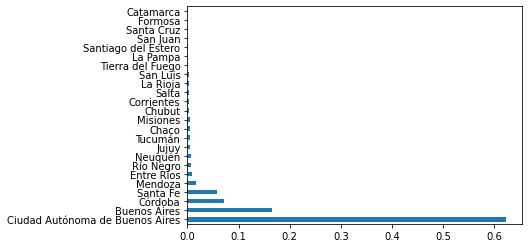

<IPython.core.display.Javascript object>

In [20]:
df = dataframe["donde_estas_trabajando"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=False)
charts["regions_percent"] = to_rechart(df)

#### 2.1.2. Roles (Posición, Open Source, Hobbie)

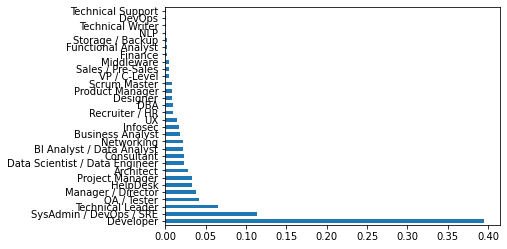

<IPython.core.display.Javascript object>

In [21]:
df = dataframe["trabajo_de"].value_counts(normalize=True, sort=True)

df[:30].plot.barh()
charts["roles_percent"] = to_rechart(df, 30)

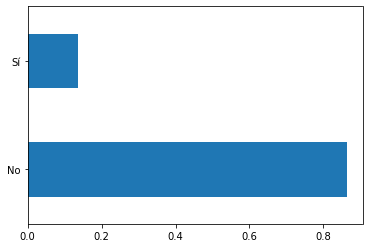

<IPython.core.display.Javascript object>

In [22]:
df = dataframe["contribuis_a_proyectos_open_source"].value_counts(
    normalize=True, sort=True
)

df.plot.barh()
charts["opensource_percent"] = to_rechart(df)

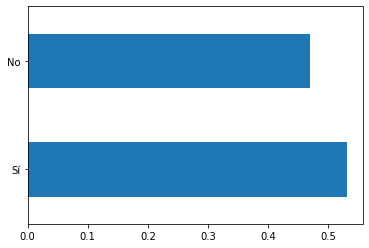

<IPython.core.display.Javascript object>

In [23]:
df = dataframe["programas_como_hobbie"].value_counts(normalize=True, sort=True)

df.plot.barh()
charts["hobbie_percent"] = to_rechart(df)

#### 2.1.3. Experiencia

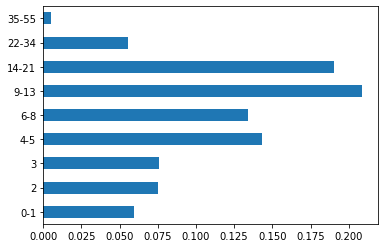

<IPython.core.display.Javascript object>

In [24]:
df = dataframe["anos_de_experiencia"].copy()
df = df.groupby(
    pd.cut(
        df.values,
        [0, 1, 2, 3, 5, 8, 13, 21, 34, 55],
        labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-34", "35-55"],
    )
).count() / len(df)

df.plot.barh()
charts["experience_years_percent"] = to_rechart(df.sort_index())

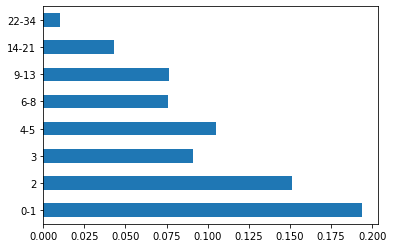

<IPython.core.display.Javascript object>

In [25]:
df = dataframe["anos_en_la_empresa_actual"].copy()
df = df.groupby(
    pd.cut(
        df.values,
        [0, 1, 2, 3, 5, 8, 13, 21, 34],
        labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-34"],
    )
).count() / len(df)

df.plot.barh()
charts["experience_years_in_company"] = to_rechart(df.sort_index())

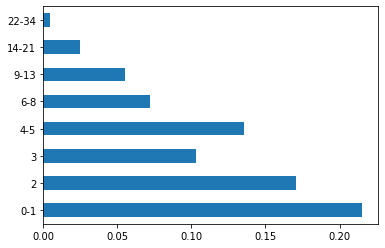

<IPython.core.display.Javascript object>

In [26]:
df = dataframe["anos_en_el_puesto_actual"].copy()
df = df.groupby(
    pd.cut(
        df.values,
        [0, 1, 2, 3, 5, 8, 13, 21, 34],
        labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-34"],
    )
).count() / len(df)

df.plot.barh()
charts["experience_years_in_position"] = to_rechart(df.sort_index())

#### 2.1.4. Educación

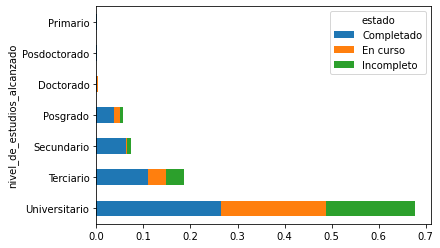

<IPython.core.display.Javascript object>

In [27]:
df = dataframe.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
) / len(
    dataframe
)

df.plot(kind="barh", stacked=True, logx=False)
charts["education_stacked"] = to_rechart(df)

28.575

Index(['Ingeniería en Sistemas de Información', 'Ingeniería en Informática',
       'Analista de Sistemas', 'Licenciatura en Sistemas de Información',
       'Licenciatura en Ciencias de la Computación',
       'Licenciatura en Informática', 'Tecnicatura en Programación',
       'Ingeniería Electrónica', 'Tecnicatura Superior en Programación',
       'Diseño Gráfico', 'Ingeniería en Computación',
       'Licenciatura en Análisis de Sistemas', 'Tecnicatura en Informática',
       'Licenciatura en Administración de Empresas',
       'Tecnicatura Superior en Sistemas Informáticos', 'Analista Programador',
       'Analista Programador Universitario',
       'Ingeniería en Telecomunicaciones', 'Telecomunicaciones',
       'Analista de Computación', 'Analista Universitario de Sistemas',
       'Diseño Multimedial', 'Tecnicatura Superior en Análisis de Sistemas',
       'Ingeniería en Software', 'Ingeniería Industrial',
       'Licenciatura en Psicología', 'Tecnicatura en Computación',
      

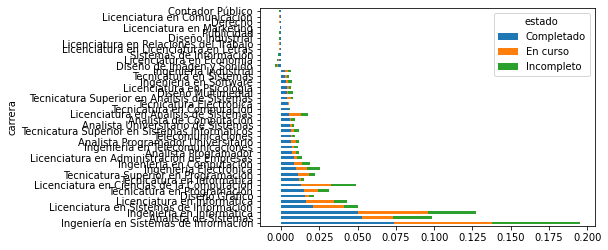

<IPython.core.display.Javascript object>

In [28]:
# Para el grado de completitud por carrera se tendrá en cuenta el tamaño de la muestra, se considerarán insuficientes los datos de aquellas carreras que representen menos del 0.5% del total

df = (
    dataframe["carrera"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("carrera > 0.005")
)

display(len(dataframe["carrera"]) * 0.005)
chosen_careers = df.index
display(chosen_careers)

df = dataframe.query('carrera != "DELETEME"')["carrera"].value_counts(
    normalize=True, sort=True
)
charts["careeres_percent"] = to_rechart(df, 40)

df = dataframe.query('carrera != "DELETEME"').groupby(["carrera", "estado"])[
    "carrera"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado", "En curso"], ascending=False
) / len(
    dataframe
)

df.loc[
    df.eval("carrera not in @chosen_careers"), ["Completado", "En curso", "Incompleto"]
] *= -1

df[:40].plot(kind="barh", stacked=True, logx=False)
charts["careeres_stacked_percent"] = to_rechart(df[:40])

/home/nad/.pyenv/versions/system-3.8.5/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


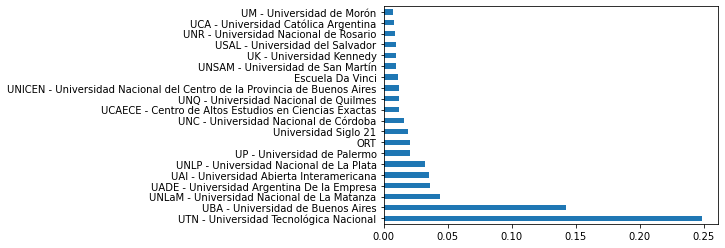

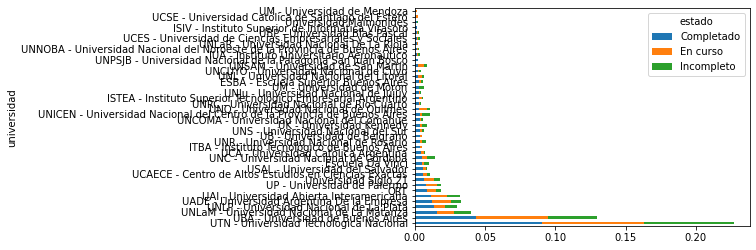

<IPython.core.display.Javascript object>

In [29]:
df = dataframe.query('universidad != "DELETEME"')["universidad"].value_counts(
    normalize=True, sort=True
)

df[:20].plot(kind="barh")
charts["universities_percent"] = to_rechart(df, 40)

df = dataframe.query('universidad != "DELETEME"').groupby(["universidad", "estado"])[
    "universidad"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado", "En curso"], ascending=False
) / len(
    dataframe
)

df[:40].plot(kind="barh", stacked=True, logx=False)
charts["universities_stacked_percent"] = to_rechart(df, 40)

/home/nad/.pyenv/versions/system-3.8.5/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/nad/.pyenv/versions/system-3.8.5/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


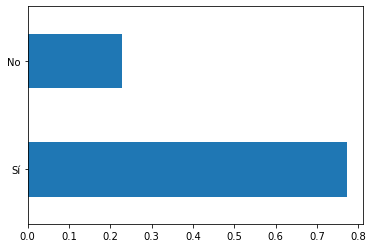

<IPython.core.display.Javascript object>

In [30]:
mask = dataframe["realizaste_cursos_de_especializacion"].str.contains("Sí")
dataframe.loc[mask, "hizo_curso"] = "Sí"
dataframe.loc[~mask, "hizo_curso"] = "No"

df = dataframe["hizo_curso"].value_counts(normalize=True, sort=True)

df.plot(kind="barh")
charts["specialization_percent"] = to_rechart(df)

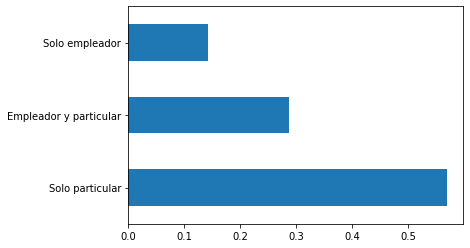

<IPython.core.display.Javascript object>

In [31]:
mask_empleador = dataframe["realizaste_cursos_de_especializacion"].str.contains(
    "un empleador"
)
mask_particular = dataframe["realizaste_cursos_de_especializacion"].str.contains(
    "de forma particular"
)

dataframe.loc[mask_particular, "quien_paga"] = "Solo particular"
dataframe.loc[mask_empleador, "quien_paga"] = "Solo empleador"
dataframe.loc[mask_empleador & mask_particular, "quien_paga"] = "Empleador y particular"

df = dataframe["quien_paga"].value_counts(normalize=True, sort=True)

df.plot(kind="barh")
charts["specialization_pays_percent"] = to_rechart(df)

#### 2.1.5. Demografía

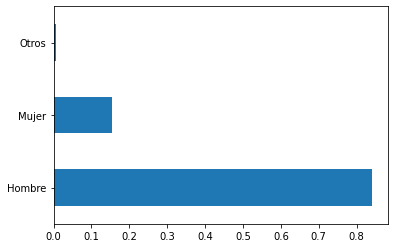

<IPython.core.display.Javascript object>

In [32]:
df = dataframe["me_identifico"].value_counts(normalize=True, sort=True)

df.plot(kind="barh")
charts["demographics_gender_percent"] = to_rechart(df)

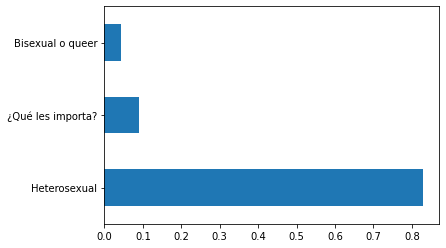

<IPython.core.display.Javascript object>

In [33]:
df = dataframe["orientacion_sexual"].value_counts(normalize=True, sort=True)

df[:3].plot(kind="barh")
charts["demographics_sexual_orientation_percent"] = to_rechart(df, 3)

### 2.2. Salarios

#### 2.2.1. Progresión Histórica

https://github.com/openqube/openqube-sueldos/blob/release/2020.02/pipeline/historical-data-analysis.ipynb

#### 2.2.2. Región

In [34]:
# Para el análisis regional se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas regiones que representen menos del 0.5% del total

df = (
    dataframe["donde_estas_trabajando"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("donde_estas_trabajando > 0.005")
)

display(len(dataframe["donde_estas_trabajando"]) * 0.005)
chosen_regions = df.index
display(chosen_regions)

28.575

Index(['Ciudad Autónoma de Buenos Aires', 'Buenos Aires', 'Córdoba',
       'Santa Fe', 'Mendoza', 'Entre Ríos', 'Río Negro', 'Neuquén', 'Jujuy',
       'Tucumán'],
      dtype='object')

<IPython.core.display.Javascript object>

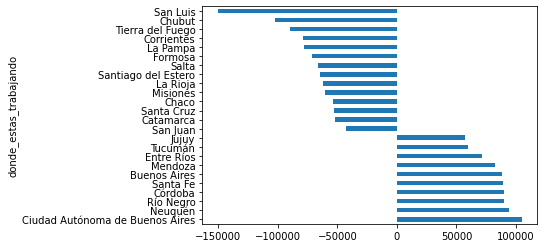

<IPython.core.display.Javascript object>

In [35]:
# Éstas serán convertidas a valores negativos, de manera de poder distinguirlas sin perjudicar a quienes deseen
# observar los resultados más allá del tamaño muestral acotado

df = dataframe.copy()

df.loc[
    df.eval("donde_estas_trabajando not in @chosen_regions"),
    "salario_mensual_bruto_en_tu_moneda_local",
] *= -1
df = (
    df.groupby(["donde_estas_trabajando"])
    .median()
    .unstack()["salario_mensual_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
)

df.plot(kind="barh")
charts["regions_salary_median"] = to_rechart(df)

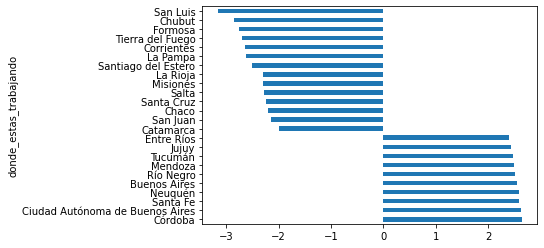

<IPython.core.display.Javascript object>

In [36]:
df = dataframe.copy()
df.loc[
    df.eval("donde_estas_trabajando not in @chosen_regions"),
    "que_tan_conforme_estas_con_tu_sueldo",
] *= -1
df = (
    df.groupby(["donde_estas_trabajando"])
    .mean()
    .unstack()["que_tan_conforme_estas_con_tu_sueldo"]
    .sort_values(ascending=False)
)

df.plot(kind="barh")
charts["regions_salary_acquiescence"] = to_rechart(df)

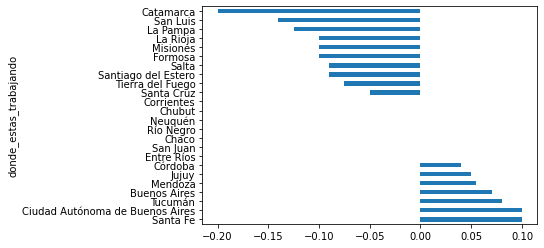

<IPython.core.display.Javascript object>

In [37]:
df = dataframe.copy()
df.loc[
    df.eval("donde_estas_trabajando not in @chosen_regions"),
    "de_que_fue_el_ajuste_total",
] *= -1
df = (
    df.groupby(["donde_estas_trabajando"])
    .median()
    .unstack()["de_que_fue_el_ajuste_total"]
    .sort_values(ascending=False)
    / 100
)

df.plot(kind="barh")
charts["regions_salary_adjustment"] = to_rechart(df)

##### 2.2.2.1. Región (mínimos por seniority) - no incluídos en el reporte

In [38]:
df = (
    dataframe.query("donde_estas_trabajando in @chosen_regions")
    .groupby(["donde_estas_trabajando", "seniority"])[
        "salario_mensual_bruto_en_tu_moneda_local"
    ]
    .min()
    .unstack()
    .sort_values(by=["Senior"], ascending=False)
)
display(df)

seniority,Junior,Semi-Senior,Senior
donde_estas_trabajando,,,
Neuquén,47945,22000,50000
Entre Ríos,21100,21300,35000
Río Negro,44500,47271,35000
Mendoza,25300,17650,30000
Jujuy,12000,36000,26000
Santa Fe,20000,18000,18000
Córdoba,15000,35000,17000
Ciudad Autónoma de Buenos Aires,11000,9500,12000
Tucumán,15000,40000,10723


<IPython.core.display.Javascript object>

##### 2.2.2.2. Región (máximos por seniority) - no incluídos en el reporte

In [39]:
df = (
    dataframe.query("donde_estas_trabajando in @chosen_regions")
    .groupby(["donde_estas_trabajando", "seniority"])[
        "salario_mensual_bruto_en_tu_moneda_local"
    ]
    .max()
    .unstack()
    .sort_values(by=["Senior"], ascending=False)
)
display(df)

seniority,Junior,Semi-Senior,Senior
donde_estas_trabajando,,,
Buenos Aires,340000,430000,450000
Ciudad Autónoma de Buenos Aires,350000,450000,450000
Córdoba,320000,380000,450000
Santa Fe,126500,320000,450000
Mendoza,99000,160000,437500
Río Negro,56000,440000,400000
Entre Ríos,190000,118000,320000
Jujuy,52000,100000,300000
Neuquén,50512,145000,200000


<IPython.core.display.Javascript object>

#### 2.2.3. Puesto

##### 2.2.3.1. Seniority

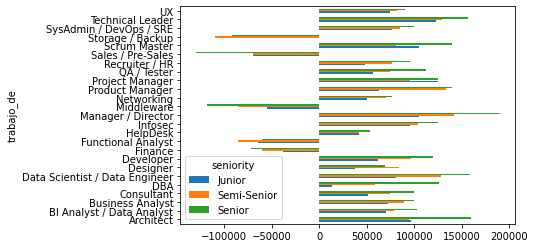

<IPython.core.display.Javascript object>

In [40]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total

df = (
    dataframe["trabajo_de"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("trabajo_de > 0.005")
)

chosen_roles = df.index
excluded_roles = {"VP / C-Level"} # Excluído 

df = dataframe["trabajo_de"].value_counts(normalize=True, sort=True)
candidate_roles = list(df[:26].index)
top_roles = [r for r in candidate_roles if r not in excluded_roles]

df = (
    dataframe.query("trabajo_de in @top_roles")
    .groupby(["trabajo_de", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_bruto_en_tu_moneda_local"]
    .fillna(0)
)  # .sort_values(by=['salario_mensual_bruto_en_tu_moneda_local'], ascending=False)

df.loc[
    df.eval("trabajo_de not in @chosen_roles"), ["Junior", "Semi-Senior", "Senior"]
] *= -1

df.plot(kind="barh")
charts["roles_seniority_salary_median"] = to_rechart(df[:30])

##### 2.2.3.1. Industria

28.575

Index(['Developer', 'SysAdmin / DevOps / SRE', 'Technical Leader',
       'QA / Tester', 'Manager / Director', 'HelpDesk', 'Project Manager',
       'Architect', 'Data Scientist / Data Engineer', 'Consultant',
       'BI Analyst / Data Analyst', 'Networking', 'Business Analyst',
       'Infosec', 'UX', 'Recruiter / HR', 'DBA', 'Designer', 'Product Manager',
       'Scrum Master'],
      dtype='object')

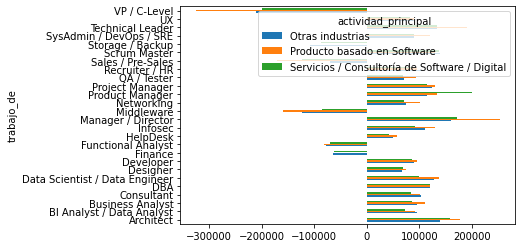

<IPython.core.display.Javascript object>

In [41]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = (
    dataframe["trabajo_de"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("trabajo_de > 0.005")
)

display(len(dataframe["trabajo_de"]) * 0.005)
chosen_roles = df.index
display(chosen_roles)


df = dataframe["trabajo_de"].value_counts(normalize=True, sort=True)
top_roles = df[:26].index

df = (
    dataframe.query("trabajo_de in @top_roles")
    .groupby(["trabajo_de", "actividad_principal"])
    .median()
    .unstack("actividad_principal")["salario_mensual_bruto_en_tu_moneda_local"]
    .fillna(0)
)  # .sort_values(by=['salario_mensual_bruto_en_tu_moneda_local'], ascending=False)

df.loc[
    df.eval("trabajo_de not in @chosen_roles"),
    [
        "Otras industrias",
        "Producto basado en Software",
        "Servicios / Consultoría de Software / Digital",
    ],
] *= -1

df.plot(kind="barh")
charts["roles_actividad_principal_salary_median"] = to_rechart(df[:30])

In [42]:
df.head()

actividad_principal,Otras industrias,Producto basado en Software,Servicios / Consultoría de Software / Digital
trabajo_de,,,
Architect,140000.0,177315.0,157917.0
BI Analyst / Data Analyst,95000.0,92000.0,72000.0
Business Analyst,95000.0,110000.0,85000.0
Consultant,103900.0,101520.0,84000.0
DBA,120000.0,120000.0,120000.0


<IPython.core.display.Javascript object>

##### 2.2.3.3. Seniority e Industria

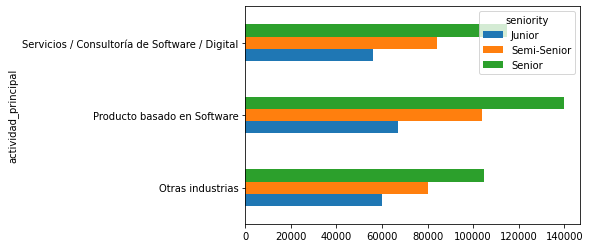

<IPython.core.display.Javascript object>

In [43]:
df = (
    dataframe.groupby(["actividad_principal", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_bruto_en_tu_moneda_local"]
)  # .sort_values(by=[''],ascending=False)

df.plot.barh()
charts["actividad_principal_seniority_salary_median"] = to_rechart(df)

##### 2.2.3.2. Open source / hobbie

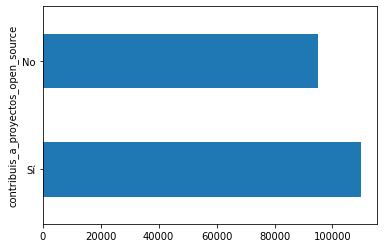

<IPython.core.display.Javascript object>

In [44]:
df = (
    dataframe.groupby(["contribuis_a_proyectos_open_source"])
    .median()
    .unstack()["salario_mensual_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
)

df.plot(kind="barh")
charts["opensource_salary_median"] = to_rechart(df)

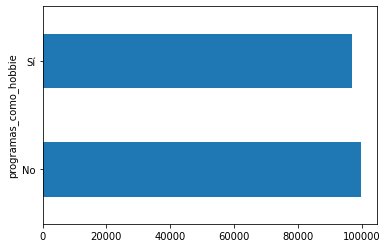

<IPython.core.display.Javascript object>

In [45]:
df = (
    dataframe.groupby(["programas_como_hobbie"])
    .median()
    .unstack()["salario_mensual_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
)

df.plot.barh()
charts["hobbie_salary_median"] = to_rechart(df)

#### 2.2.4. Carrera

In [46]:
df = dataframe.groupby(["carrera", "estado"])["carrera"].count().unstack(
    "estado"
).fillna(0).sort_values(by=["Completado", "En curso"], ascending=False) / len(dataframe)

top_careers = df[:30].index

# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = df[:30]["Completado"].to_frame().query("Completado > 0.005")
display(df)
chosen_careers = df.index

,Completado
carrera,
Ingeniería en Sistemas de Información,0.073841
Analista de Sistemas,0.052668
Ingeniería en Informática,0.050569
Licenciatura en Sistemas de Información,0.020997
Licenciatura en Informática,0.016273
Diseño Gráfico,0.015398
Tecnicatura en Programación,0.014873
Licenciatura en Ciencias de la Computación,0.012948
Tecnicatura en Informática,0.011549


<IPython.core.display.Javascript object>

##### 2.2.4.1. Según Seniority

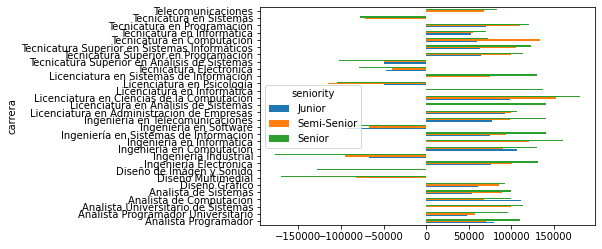

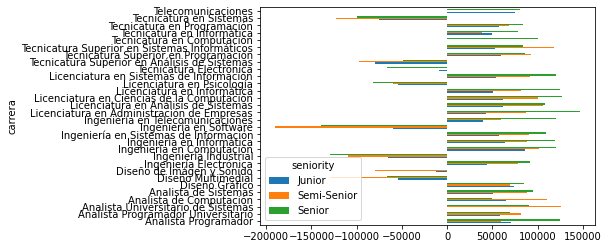

<IPython.core.display.Javascript object>

In [47]:
df = dataframe.query('estado == "Completado"').copy()
df = invert_non_representative_values(df, "carrera", chosen_careers)
df = filter_valid_top_values(df, "carrera", top_careers)
df = get_two_dimensional_median_with_outliers_filtered(
    df, ["carrera", "seniority"], "salario_mensual_bruto_en_tu_moneda_local"
)

df[:30].plot(kind="barh")
charts["carrera_seniority_salary_median"] = to_rechart(df[:30])


df = dataframe.query('estado == "En curso"').copy()
df = invert_non_representative_values(df, "carrera", chosen_careers)
df = filter_valid_top_values(df, "carrera", top_careers)
df = get_two_dimensional_median_with_outliers_filtered(
    df, ["carrera", "seniority"], "salario_mensual_bruto_en_tu_moneda_local"
)

df[:30].plot(kind="barh")
charts["carrera_seniority_salary_median_encurso"] = to_rechart(df[:30])

In [48]:
# Cuántos Ingenieros Industriales hay en el resultado obtenido, ya que sobresale del resto
df = dataframe.query('carrera in ["Ingeniería Industrial"] & estado == "Completado"')[
    ["seniority", "trabajo_de", "salario_mensual_bruto_en_tu_moneda_local"]
].sort_values(by=["salario_mensual_bruto_en_tu_moneda_local"], ascending=False)

display("Un {:.2f}%".format(len(df) / len(dataframe) * 100))
display(df)

'Un 0.28%'

,seniority,trabajo_de,salario_mensual_bruto_en_tu_moneda_local
1353,Semi-Senior,Manager / Director,400000
4741,Senior,Sales / Pre-Sales,270000
48,Senior,Product Manager,235500
732,Senior,Data Scientist / Data Engineer,235000
1649,Senior,Architect,177000
2324,Junior,BI Analyst / Data Analyst,167000
5644,Senior,BI Analyst / Data Analyst,165000
328,Senior,Developer,145000
5846,Semi-Senior,Data Scientist / Data Engineer,100000
4570,Semi-Senior,Business Analyst,95600


<IPython.core.display.Javascript object>

##### 2.2.4.2. Según Estado de la Carrera

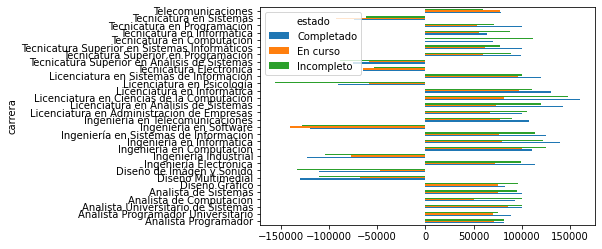

<IPython.core.display.Javascript object>

In [49]:
df = dataframe.copy()
df = invert_non_representative_values(df, "carrera", chosen_careers)
df = filter_valid_top_values(df, "carrera", top_careers)
df = get_two_dimensional_median_with_outliers_filtered(
    df, ["carrera", "estado"], "salario_mensual_bruto_en_tu_moneda_local"
)

df[:30].plot(kind="barh")
charts["carrera_estado_salary_median"] = to_rechart(df[:30])

##### 2.2.4.3. Según Nivel de Estudios Alcanzado

28.575

Index(['Universitario', 'Terciario', 'Secundario', 'Posgrado'], dtype='object')

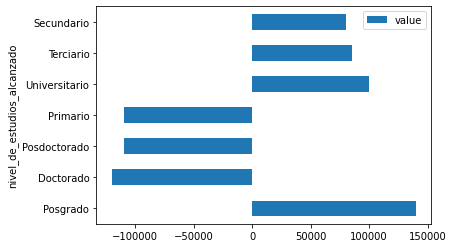

<IPython.core.display.Javascript object>

In [50]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = (
    dataframe["nivel_de_estudios_alcanzado"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("nivel_de_estudios_alcanzado > 0.005")
)

display(len(dataframe["nivel_de_estudios_alcanzado"]) * 0.005)
chosen_levels = df.index
display(chosen_levels)

df = (
    dataframe.groupby(["nivel_de_estudios_alcanzado"])
    .median()
    .unstack()["salario_mensual_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
    .to_frame("value")
)
df.loc[df.eval("nivel_de_estudios_alcanzado not in @chosen_levels"), "value"] *= -1

df.plot(kind="barh")
charts["nivel_estudios_salary_median"] = to_rechart(df)

##### 2.2.4.4. Según hicieron o no Cursos de Especialización

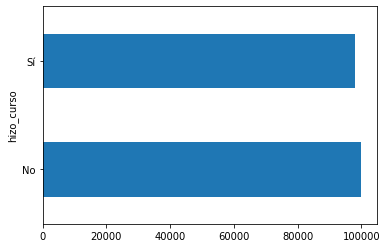

<IPython.core.display.Javascript object>

In [51]:
df = (
    dataframe.groupby(["hizo_curso"])
    .median()
    .unstack()["salario_mensual_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
)

df.plot(kind="barh")
charts["hizo_curso_salary_median"] = to_rechart(df)

#### 2.2.5. Tecnología

##### 2.2.5.1. Según Plataformas

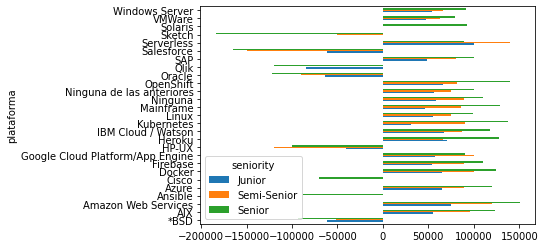

<IPython.core.display.Javascript object>

In [52]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = (
    dataframe["plataformas"]
    .str.extractall(r"(?P<count>[^,]+),? ?")["count"]
    .value_counts(normalize=True, sort=True)
)

top_platforms = df[:30].index
excluded_platforms = {"OpenStack"} # Excluída para mantener escala
chosen_platforms = df.to_frame().query("count > 0.005").index

df = dataframe.copy()
df = (
    df["plataformas"]
    .str.split(",")
    .apply(pd.Series)
    .merge(df, right_index=True, left_index=True)
    .drop(["plataformas"], axis=1)
    .melt(
        id_vars=["seniority", "salario_mensual_bruto_en_tu_moneda_local"],
        value_name="plataforma",
    )
    .drop(["variable"], axis=1)
    .dropna()
    .query("plataforma in @top_platforms")
    .query("plataforma not in @excluded_platforms")
    .groupby(["plataforma", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_bruto_en_tu_moneda_local"]
    .fillna(0)
)

df.loc[
    df.eval("plataforma not in @chosen_platforms"), ["Junior", "Semi-Senior", "Senior"]
] *= -1

df[:30].plot(kind="barh")
charts["plataformas_seniority_salary_median"] = to_rechart(df[:30])

##### 2.2.5.2. Según Lenguajes de Programación

seniority,Junior,Semi-Senior,Senior
lenguaje_de_programacion,,,
.NET,58800.0,85000.0,120000.0
ABAP,-49475.0,-90000.0,-100000.0
ActionScript,-48000.0,-60000.0,-115000.0
Bash/Shell,67500.0,97500.0,125000.0
C,46724.0,75000.0,125000.0
C#,51700.0,71612.5,112500.0
C++,40000.0,86000.0,87000.0
COBOL,-48600.0,-104500.0,-140000.0
CSS,60000.0,90000.0,120000.0


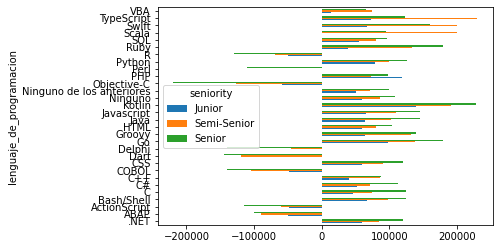

<IPython.core.display.Javascript object>

In [53]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = (
    dataframe["lenguajes_de_programacion"]
    .str.extractall(r"(?P<count>[^,]+),? ?")["count"]
    .value_counts(normalize=True, sort=True)
)
top_languages = df[:30].index

chosen_languages = df.to_frame().query("count > 0.005").index

df = dataframe.copy()
df = (
    df["lenguajes_de_programacion"]
    .str.split(",")
    .apply(pd.Series)
    .merge(df, right_index=True, left_index=True)
    .drop(["lenguajes_de_programacion"], axis=1)
    .melt(
        id_vars=["seniority", "salario_mensual_bruto_en_tu_moneda_local"],
        value_name="lenguaje_de_programacion",
    )
    .drop(["variable"], axis=1)
    .dropna()
    .query("lenguaje_de_programacion in @top_languages")
    .groupby(["lenguaje_de_programacion", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_bruto_en_tu_moneda_local"]
    .fillna(0)
)

df.loc[
    df.eval("lenguaje_de_programacion not in @chosen_languages"),
    ["Junior", "Semi-Senior", "Senior"],
] *= -1

display(df)
df.plot(kind="barh")
charts["lenguajes_de_programacion_seniority_salary_median"] = to_rechart(df[:30])

##### 2.2.6. Otras compensaciones

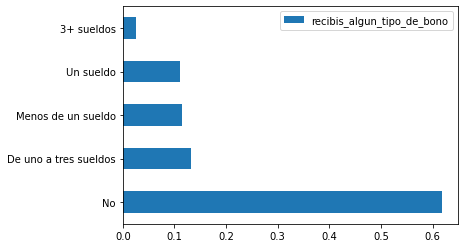

<IPython.core.display.Javascript object>

In [54]:
df = (
    dataframe["recibis_algun_tipo_de_bono"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
)

df.plot(kind="barh")
charts["bonos_percent"] = to_rechart(df)

#### 2.2.6. Tipo de contrato

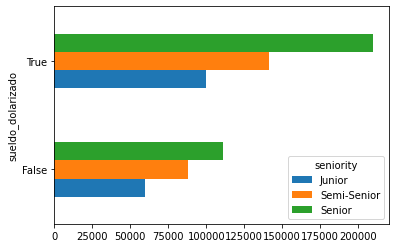

<IPython.core.display.Javascript object>

In [55]:
df = (
    dataframe.groupby(["sueldo_dolarizado", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_bruto_en_tu_moneda_local"]
    .fillna(0)
)  # .sort_values(by=['salario_mensual_bruto_en_tu_moneda_local'], ascending=False)
df.plot(kind="barh")
charts["sueldo_dolarizado_salary_median"] = to_rechart(df)

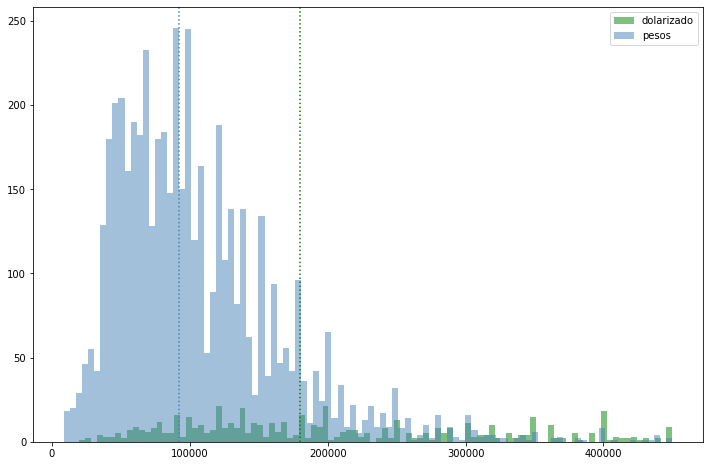

<IPython.core.display.Javascript object>

In [56]:
_, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)
_dolar = dataframe[dataframe.sueldo_dolarizado].salario_mensual_bruto_en_tu_moneda_local
_no_dolar = dataframe[
    ~dataframe.sueldo_dolarizado
].salario_mensual_bruto_en_tu_moneda_local
ax.hist(_dolar, bins=100, label="dolarizado", alpha=0.5, color="green")
ax.hist(_no_dolar, bins=100, label="pesos", alpha=0.5, color="steelblue")
ax.axvline(_dolar.median(), color="green", linestyle="dotted")
ax.axvline(_no_dolar.median(), color="steelblue", linestyle="dotted")
ax.legend()

### 2.3. Género

#### 2.3.1. Progresión Histórica

#### 2.3.2. Preparación

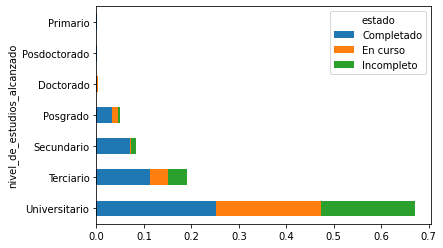

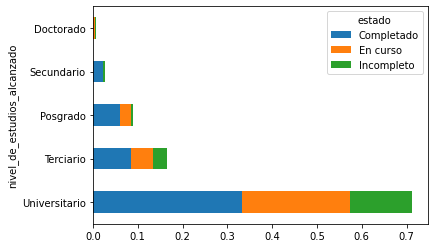

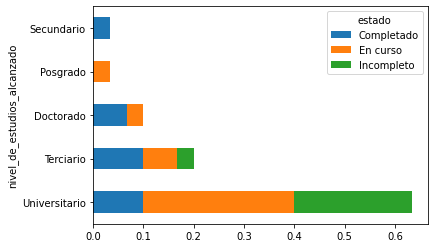

<IPython.core.display.Javascript object>

In [57]:
df = dataframe.query('me_identifico == "Hombre"')
df = df.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
) / len(
    df
)
df.plot(kind="barh", stacked=True, logx=False)
charts["education_hombre_stacked"] = to_rechart(df)

df = dataframe.query('me_identifico == "Mujer"')
df = df.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
) / len(
    df
)
df.plot(kind="barh", stacked=True, logx=False)
charts["education_mujer_stacked"] = to_rechart(df)

df = dataframe.query('me_identifico == "Otros"')
df = df.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
).sort_values(
    by=["En curso"], ascending=False
) / len(
    df
)
df.plot(kind="barh", stacked=True, logx=False)
charts["education_otros_stacked"] = to_rechart(df)

#### 2.3.3. Salarios

In [58]:
# df = dataframe['trabajo_de'].value_counts(normalize=True, sort=True)
# top_roles = df[:26].index

# df = dataframe.query('(trabajo_de in @top_roles) & (seniority == "Junior")')
# df = df.groupby(['trabajo_de', 'me_identifico']).median().unstack('me_identifico')['salario_mensual_bruto_en_tu_moneda_local'].fillna(0)
# df.loc[ df.eval('trabajo_de not in @chosen_roles'), ['Hombre', 'Mujer', 'Otros']] *= -1
# charts['roles_seniority_salary_junior_median'] = to_rechart(df, 30)
# df.plot(kind='barh')

# df = dataframe.query('(trabajo_de in @top_roles) & (seniority == "Semi-Senior")')
# df = df.groupby(['trabajo_de', 'me_identifico']).median().unstack('me_identifico')['salario_mensual_bruto_en_tu_moneda_local'].fillna(0)
# df.loc[ df.eval('trabajo_de not in @chosen_roles'), ['Hombre', 'Mujer', 'Otros']] *= -1
# charts['roles_seniority_salary_semisenior_median'] = to_rechart(df, 30)
# df.plot(kind='barh')

# df = dataframe.query('(trabajo_de in @top_roles) & (seniority == "Senior")')
# df = df.groupby(['trabajo_de', 'me_identifico']).median().unstack('me_identifico')['salario_mensual_bruto_en_tu_moneda_local'].fillna(0)
# df.loc[ df.eval('trabajo_de not in @chosen_roles'), ['Hombre', 'Mujer', 'Otros']] *= -1
# charts['roles_seniority_salary_senior_median'] = to_rechart(df, 30)
# df.plot(kind='barh')

<IPython.core.display.Javascript object>

In [59]:
df = dataframe["trabajo_de"].value_counts(normalize=True, sort=True)
top_roles = df[:26].index

top_salary_roles = (
    dataframe.query("trabajo_de in @top_roles")
    .groupby(["trabajo_de"])
    .median()["salario_mensual_bruto_en_tu_moneda_local"]
    .fillna(0)
    .sort_values(0, ascending=False)
    .index.tolist()
)
top_salary_roles_mujer = (
    dataframe.query('trabajo_de in @top_roles & me_identifico == "Mujer"')
    .groupby(["trabajo_de"])
    .median()["salario_mensual_bruto_en_tu_moneda_local"]
    .fillna(0)
    .sort_values(0, ascending=False)
    .index.tolist()
)

# Roles mejores pagos en los que no se encuentran mujeres
display([rol for rol in top_salary_roles if rol not in top_salary_roles_mujer])

['Storage / Backup']

<IPython.core.display.Javascript object>

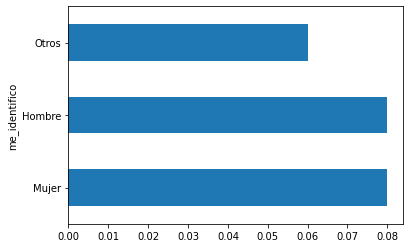

<IPython.core.display.Javascript object>

In [60]:
df = (
    dataframe.groupby(["me_identifico"])
    .median()
    .unstack()["de_que_fue_el_ajuste_total"]
    .sort_values(ascending=False)
    / 100
)

df.plot(kind="barh")
charts["gender_salary_adjustment"] = to_rechart(df)

#### 2.3.4. Experiencia

me_identifico,Hombre,Mujer,Otros
actividad_principal,,,
Otras industrias,0.856629,0.138572,0.004799
Producto basado en Software,0.840786,0.152826,0.006388
Servicios / Consultoría de Software / Digital,0.830601,0.164928,0.004471


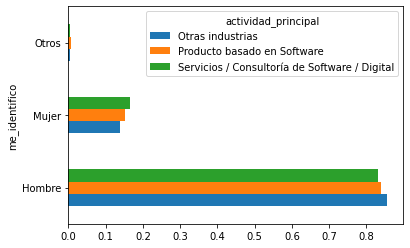

<IPython.core.display.Javascript object>

In [61]:
df = dataframe
df = (
    df.groupby(["actividad_principal", "me_identifico"])
    .agg({"me_identifico": "count"})
    .groupby(level=0)
    .apply(lambda x: x / float(x.sum()))
    .unstack("me_identifico")
)
df.columns = df.columns.droplevel(0)
display(df)
df.T.plot(kind="barh")
charts["actividad_principal_gender_percent"] = to_rechart(df)

me_identifico,Hombre,Mujer,Otros
anos_de_experiencia_fibo,,,
0-1,0.790560,0.203540,0.005900
2,0.786047,0.204651,0.009302
3,0.813793,0.179310,0.006897
4-5,0.841076,0.152812,0.006112
6-8,0.833333,0.162760,0.003906
9-13,0.858340,0.139145,0.002515
14-21,0.893284,0.103036,0.003680
22-55,0.901449,0.089855,0.008696


/home/nad/.pyenv/versions/system-3.8.5/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


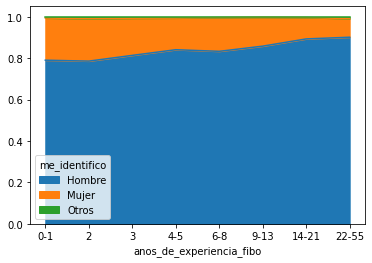

<IPython.core.display.Javascript object>

In [62]:
df = dataframe.copy()
df["anos_de_experiencia_fibo"] = pd.cut(
    df["anos_de_experiencia"].values,
    [0, 1, 2, 3, 5, 8, 13, 21, 55],
    labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-55"],
)
df = (
    df.groupby(["anos_de_experiencia_fibo", "me_identifico"])
    .agg({"me_identifico": "count"})
    .groupby(level=0)
    .apply(lambda x: x / float(x.sum()))
    .unstack("me_identifico")
    .fillna(0)
)
df.columns = df.columns.droplevel(0)
display(df)
df.plot(kind="area")
charts["experience_gender_percent"] = to_rechart(df)

me_identifico,Hombre,Mujer,Otros
anos_de_experiencia_fibo,,,
0-1,53892.5,52200.0,54500.0
2,70000.0,65528.5,93500.0
3,80000.0,83000.0,55000.0
4-5,98500.0,89000.0,102500.0
6-8,109500.0,100000.0,150000.0
9-13,120000.0,115500.0,93000.0
14-21,130000.0,107500.0,275000.0
22-55,120000.0,92914.0,98000.0


/home/nad/.pyenv/versions/system-3.8.5/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


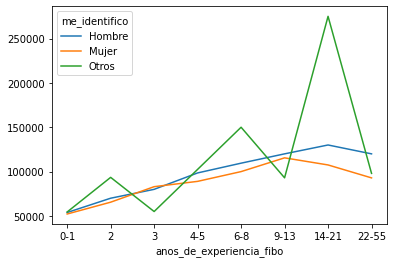

<IPython.core.display.Javascript object>

In [63]:
df = dataframe.copy()
df["anos_de_experiencia_fibo"] = pd.cut(
    df["anos_de_experiencia"].values,
    [0, 1, 2, 3, 5, 8, 13, 21, 55],
    labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-55"],
)
df = (
    df.groupby(["anos_de_experiencia_fibo", "me_identifico"])
    .agg({"salario_mensual_bruto_en_tu_moneda_local": "median"})
    .unstack("me_identifico")
    .fillna(0)
)
df.columns = df.columns.droplevel(0)
display(df)
df.plot(kind="line")
charts["experience_gender_salary_median"] = to_rechart(df)

me_identifico,Hombre,Mujer,Otros
anos_de_experiencia_fibo,,,
0-1,2.567164,2.579710,3.000000
2,2.517751,2.659091,2.750000
3,2.564972,2.730769,2.666667
4-5,2.594477,2.608000,2.200000
6-8,2.645313,2.568000,3.333333
9-13,2.655273,2.686747,1.666667
14-21,2.606591,2.500000,2.500000
22-55,2.491961,2.387097,2.666667


/home/nad/.pyenv/versions/system-3.8.5/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


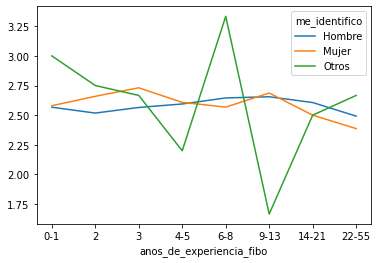

<IPython.core.display.Javascript object>

In [64]:
df = dataframe.copy()
df["anos_de_experiencia_fibo"] = pd.cut(
    df["anos_de_experiencia"].values,
    [0, 1, 2, 3, 5, 8, 13, 21, 55],
    labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-55"],
)
df = (
    df.groupby(["anos_de_experiencia_fibo", "me_identifico"])
    .agg({"que_tan_conforme_estas_con_tu_sueldo": "mean"})
    .unstack("me_identifico")
    .fillna(0)
)
df.columns = df.columns.droplevel(0)
display(df)
df.plot(kind="line")
charts["experience_gender_conformidad_mean"] = to_rechart(df)

#### 2.3.5. Discapacidad

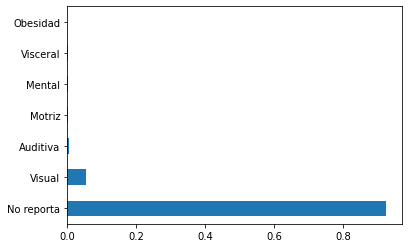

<IPython.core.display.Javascript object>

In [65]:
df = dataframe["tenes_algun_tipo_de_discapacidad"].fillna("No reporta").value_counts(
    normalize=False, sort=True
) / len(dataframe)

# df = dataframe['tenes_algun_tipo_de_discapacidad'].value_counts(normalize=True, sort=True)#.to_frame()

df[:7].plot(kind="barh")
charts["discapacidad_percent"] = to_rechart(df, 7)

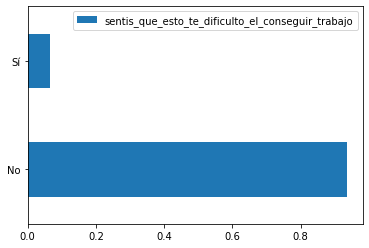

<IPython.core.display.Javascript object>

In [66]:
# Quienes respondieron Sí o No, son quienes contestaron sobre discapacidad.  El resto es None
df = (
    dataframe["sentis_que_esto_te_dificulto_el_conseguir_trabajo"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
)

df.plot(kind="barh")
charts["discapacidad_dificultad_percent"] = to_rechart(df)

### 2.4. Tecnología

#### 2.4.1. Plataformas más populares

'reduced in 0.020710'

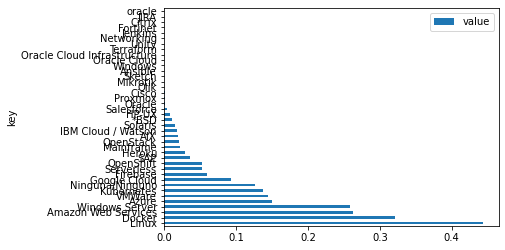

<IPython.core.display.Javascript object>

In [67]:
df = (
    dataframe["plataformas"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        "Google Cloud Platform/App Engine": "Google Cloud",
        "Sap": "SAP",
        "crm": "CRM",
        "Ninguna de las anteriores": "Ninguna/Ninguno",
        "^(nada|no|ningun[ao]|otros?|0|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:40].plot.barh()
charts["plataformas"] = to_rechart(df[:40])

#### 2.4.2. Lenguajes de Programación más populares

'reduced in 0.047619'

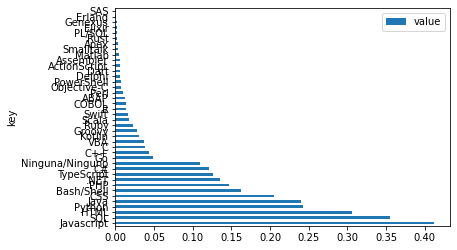

<IPython.core.display.Javascript object>

In [68]:
df = (
    dataframe["lenguajes_de_programacion"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        "powershell": "PowerShell",
        "cobol": "COBOL",
        "Ninguno de los anteriores": "Ninguna/Ninguno",
        "^(nada|no|ningun[ao]|otros?|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:40].plot.barh()
charts["lenguajes_de_programacion"] = to_rechart(df[:40])

#### 2.4.3. Frameworks, Herramientas y Librerías más populares

'reduced in 0.042017'

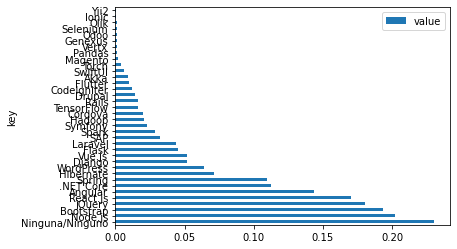

<IPython.core.display.Javascript object>

In [69]:
df = (
    dataframe["frameworksherramientas_y_librerias"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        ".*(node).*$": "Node.js",
        ".*Angular.*$": "Angular",
        ".*React.*$": "React.js",
        ".*Vue.*$": "Vue.js",
        ".*jquery.*$": "jQuery",
        ".*laravel.*$": "Laravel",
        ".*codeigniter.*$": "CodeIgniter",
        ".*struts.*$": "Struts",
        "Ninguno de los anteriores": "Ninguna/Ninguno",
        "^(nada|no|ningun[ao]|otros?|0|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:36].plot.barh()
charts["frameworksherramientas_y_librerias"] = to_rechart(df[:36])

#### 2.4.4. Bases de Datos más populares

'reduced in 0.041958'

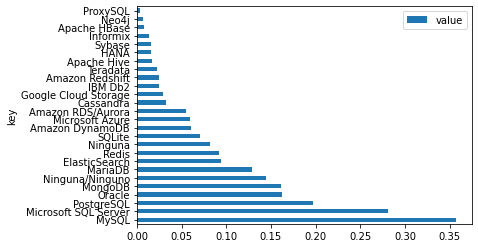

<IPython.core.display.Javascript object>

In [70]:
df = (
    dataframe["bases_de_datos"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        ".*(sybase).*$": "Sybase",
        "Microsoft Azure \(Tables": "Microsoft Azure",
        "Ninguna de las anteriores": "Ninguna/Ninguno",
        "^(SQL|CosmosDB|etc\)|otros?|0|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:26].plot.barh()
charts["bases_de_datos"] = to_rechart(df[:26])

#### 2.4.5. Herramientas de QA / Testing más populares

'reduced in 0.147465'

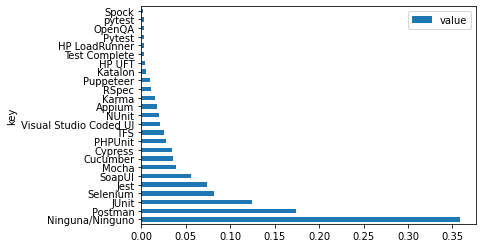

<IPython.core.display.Javascript object>

In [71]:
df = (
    dataframe["qa_testing"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        ".*(ningun[oa]|no|nada|otros?|0|\.).*$": "DELETEME",
        ".*(junit).*$": "JUnit",
        ".*(jest).*$": "Jest",
        "Ninguna de las anteriores": "Ninguna/Ninguno",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:25].plot.barh()
charts["qa_testing"] = to_rechart(df[:25])

#### 2.4.6. IDEs más populares

'reduced in 0.123188'

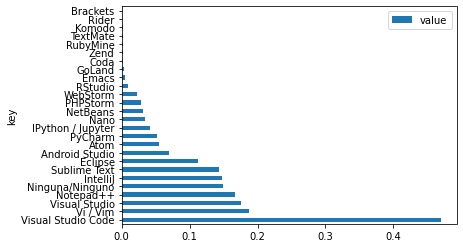

<IPython.core.display.Javascript object>

In [72]:
df = (
    dataframe["ides"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        "^.*(Visual Studio|VS).*$": "Visual Studio",
        "^.*(Visual Studio Code|VS ?Code|Code).*$": "Visual Studio Code",
        ".*(Sublime)( Text)?.*$": "Sublime Text",
        ".*(webstorm).*$": "WebStorm",
        "^(vi|vim)$": "Vi / Vim",
        "^(jdeveloper)$": "JDeveloper",
        "^(goland)$": "GoLand",
        "^(neovim)$": "NeoVim",
        "IBM integración toolkit": "IBM Integration Bus",
        "^(rubymine)$": "RubyMine",
        "Ninguno de los anteriores": "Ninguna/Ninguno",
        "^(no( uso.*| util.*)?|none|ningun[ao]|0|No s[eé]|nada|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:26].plot.barh()
charts["ides"] = to_rechart(df[:26])

### 2.5. Trabajo

#### 2.5.1. Tipos de contrato

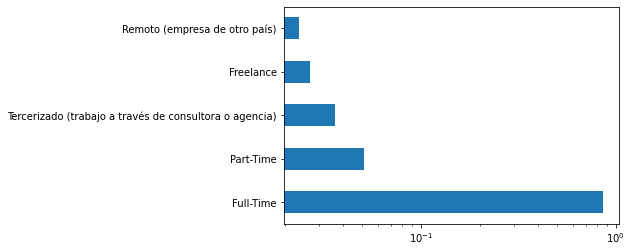

<IPython.core.display.Javascript object>

In [73]:
df = dataframe["tipo_de_contrato"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=True)
charts["tipo_de_contrato_percent"] = to_rechart(df)

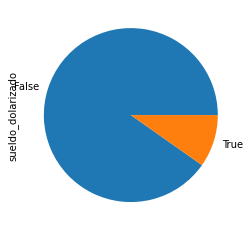

<IPython.core.display.Javascript object>

In [74]:
df = dataframe["sueldo_dolarizado"].value_counts(normalize=True, sort=True)
df.plot.pie()
charts["sueldo_dolarizado_percent"] = to_rechart(df)

#### 2.5.2. Compensación

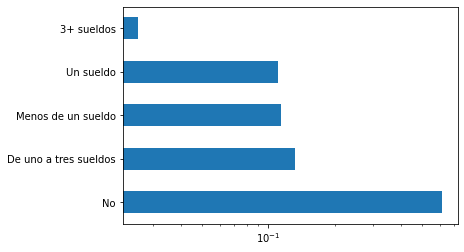

<IPython.core.display.Javascript object>

In [75]:
df = dataframe["recibis_algun_tipo_de_bono"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=True)
charts["recibis_algun_tipo_de_bono"] = to_rechart(df)

'reduced in 0.196923'

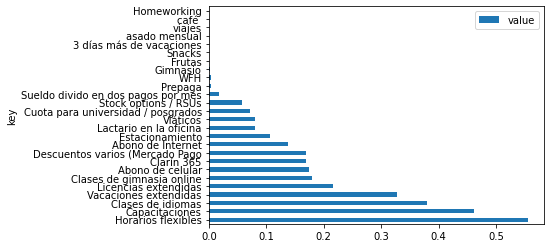

<IPython.core.display.Javascript object>

In [76]:
df = (
    dataframe["beneficios_extra"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        ".*Vacaciones flexibles.*$": "Vacaciones extendidas",
        ".*Licencias?.*$": "Licencias extendidas",
        "horarios? flexibles?$": "Horarios flexibles",
        "(.*capacitaci[oó]n(es)?.*|.*cursos?.*)$": "Capacitaciones",
        "bebidas?$": "Bebidas",
        "(golosinas?|snac?ks?)$": "Snacks",
        "(Descuentos varios \(Clarín 365)$": "Descuentos varios",
        "(etc\)|Club La Nación)$": "DELETEME",
        "(no|.*Nada.*|Ning[uú]n[ao]?( de las anteriores)?)$": "DELETEME",
        "(.*prepaga.*|OSDE|.*obra social.*)$": "Prepaga",
        "(frut[ao]s?)$": "Frutas",
        "(facturas?)": "Facturas",
        "(.*home off?ice.*|.*WFH.*|.*home work.*)$": "WFH",
        "(.*d[oó]lares.*|Sueldo dolarizado)$": "Sueldo dolarizado",
        "(.*gimnasio.*|.*gym.*)$": "Gimnasio",
        "(.*cochera.*|.*estacionamiento.*)$": "Estacionamiento",
        "(.*combustibles?.*|.*vi[aá]ticos?.*|.*cabify.*|.*transporte.*|.*remis.*)$": "Viáticos",
        "(.*sueldos? ex.*)$": "Sueldos extra",
        "(.*eventos?.*|entradas?)$": "Eventos",
        "(.*pileta)$": "Pileta",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:26].plot.barh()
charts["beneficios_extra"] = to_rechart(df[:26])

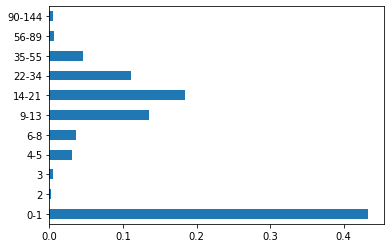

<IPython.core.display.Javascript object>

In [77]:
df = dataframe["de_que_fue_el_ajuste_total"].copy()
df = df.groupby(
    pd.cut(
        df.values,
        [0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144],
        labels=[
            "0-1",
            "2",
            "3",
            "4-5",
            "6-8",
            "9-13",
            "14-21",
            "22-34",
            "35-55",
            "56-89",
            "90-144",
        ],
        include_lowest=True,
    )
).count() / len(df)

df.plot.barh()
charts["de_que_fue_el_ajuste"] = to_rechart(df.sort_index())

#### 2.5.3. Características de la Empresa

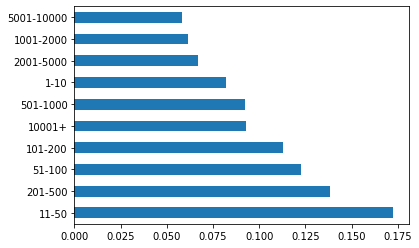

<IPython.core.display.Javascript object>

In [78]:
df = dataframe["cantidad_de_empleados"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=False)
charts["cantidad_de_empleados"] = to_rechart(df)

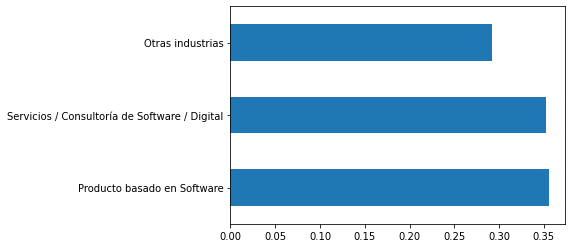

<IPython.core.display.Javascript object>

In [79]:
df = dataframe["actividad_principal"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=False)
charts["actividad_principal"] = to_rechart(df)

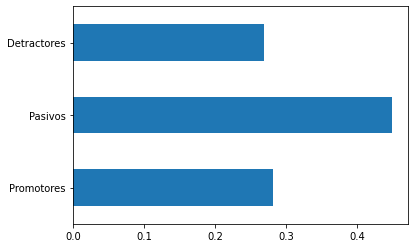

<IPython.core.display.Javascript object>

In [80]:
df = dataframe["la_recomendas_como_un_buen_lugar_para_trabajar"].copy()
# https://es.wikipedia.org/wiki/Net_Promoter_Score
df = df.groupby(
    pd.cut(df.values, [0, 6, 8, 10], labels=["Detractores", "Pasivos", "Promotores"])
).count() / len(df)
df = df.iloc[::-1]  # reverse order

df.plot.barh()
charts["la_recomendas_como_un_buen_lugar_para_trabajar"] = to_rechart(df)

'reduced in 0.112918'

,value
key,
MercadoLibre,0.123360
Globant,0.033946
Medallia,0.033421
MuleSoft,0.021522
Santander,0.012073
Accenture,0.011374
Google,0.010324
Auth0,0.008749
ASAPP,0.008399


<AxesSubplot:ylabel='key'>

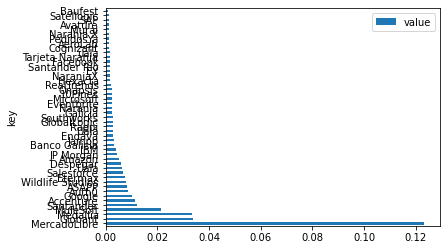

<IPython.core.display.Javascript object>

In [81]:
df = (
    dataframe[
        "cuales_consideras_que_son_las_mejores_empresas_de_it_para_trabajar_en_este_momentoen_tu_ciudad"
    ]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        "^(ningun[ao]|-|no lo se|desconozco|ni idea|no s[ée]|Son todas una mierda\.|bancos?)$": "DELETEME",
        "^(mercadolibre|mercado libre|meli|ml|mercado ?pago)$": "MercadoLibre",
        "^(medallia|medalia)$": "Medallia",
        "^(despegar\.?(com)?)$": "Despegar",
        "^(mulesoft)$": "Mulesoft",
        "^(globant)$": "Globant",
        "^(google)$": "Google",
        "^(auth0)$": "Auth0",
        "^(rappi)$": "Rappi",
        "^(jampp?)$": "Jampp",
        "^(asapp|asap)$": "ASAPP",
        "^(ibm|i\.b\.m\.?)$": "IBM",
        "^(aws|amazon)$": "Amazon",
        "^(eventbrite)$": "Eventbrite",
        "^(saleforce|salesforce)$": "Salesforce",
        "^(olx|o\.l\.x\.?)$": "OLX",
        "^(10 ?pines)$": "10Pines",
        "^(microsoft)$": "Microsoft",
        "^(jp ?morgan)$": "JP Morgan",
        "^(elementum)$": "Elementum",
        "^(bell?atrix)$": "Belatrix",
        "^(nubank)$": "Nubank",
        "^(etermax)$": "Etermax",
        "^(facebook)$": "Facebook",
        "^(hexacta)$": "Hexacta",
        "^(oracle)$": "Oracle",
        "^(avature)$": "Avature",
        "^(everis)$": "Everis",
        "^(baires ?dev)$": "NubaBairesDevnk",
        "^(stensul)$": "Stensul",
        "^(satel? ?logic\.?)$": "Satellogic",
        "^(scale)$": "Scale",
        "^(aerolab)$": "AeroLab",
        "^(rga|r/ga)$": "R/GA",
        "^(accenture)$": "Accenture",
        "^(olapic)$": "Olapic",
        "^(logicalis)$": "Logicalis",
        "^(mule ?(soft)?)$": "MuleSoft",
        "^(soft ?vision)$": "SoftVision",
        "^(global ?logic)$": "GlobalLogic",
        "^(pedidos ?ya)$": "PedidosYa",
        "^(decentra ?land)$": "DecentraLand",
        "^(real ?trends)$": "RealTrends",
        "^(nubi ?lmetri(x|cs))$": "Nubimetrics",
        "^(santander( tec.*))$": "Santander",
        "^(wildlife|wildlife*)$": "Wildlife Studios",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)
display(df[:47])
df[:47].plot.barh()

## 3. Publicación

In [82]:
import json

# formateamos valores flotantes para ahorrar caracteres (#macritips)
display(
    json.dumps(
        json.loads(
            json.dumps(charts, allow_nan=False),
            parse_float=lambda x: round(float(x), 5),
        )
    )
)

'{"total_surveyed": 6095, "total_analyzed_surveyed": 5715, "regions_percent": {"data": [{"name": "Ciudad Aut\\u00f3noma de Buenos Aires", "value": 0.6231}, {"name": "Buenos Aires", "value": 0.16535}, {"name": "C\\u00f3rdoba", "value": 0.07227}, {"name": "Santa Fe", "value": 0.05862}, {"name": "Mendoza", "value": 0.0175}, {"name": "Entre R\\u00edos", "value": 0.0098}, {"name": "R\\u00edo Negro", "value": 0.00647}, {"name": "Neuqu\\u00e9n", "value": 0.0063}, {"name": "Jujuy", "value": 0.00595}, {"name": "Tucum\\u00e1n", "value": 0.00542}, {"name": "Chaco", "value": 0.0042}, {"name": "Misiones", "value": 0.00402}, {"name": "Chubut", "value": 0.0035}, {"name": "Corrientes", "value": 0.00297}, {"name": "Salta", "value": 0.00245}, {"name": "La Rioja", "value": 0.00227}, {"name": "San Luis", "value": 0.0021}, {"name": "Tierra del Fuego", "value": 0.00175}, {"name": "La Pampa", "value": 0.0014}, {"name": "Santiago del Estero", "value": 0.0014}, {"name": "San Juan", "value": 0.00122}, {"name": 

<IPython.core.display.Javascript object>